# Pizza or Not Pizza 분류(VGG 안 쓴 버전)
- 프로젝트에 사용된 파일

In [183]:
# 모듈 로딩
import pandas as pd
import numpy as np

from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt

# 데이터 불러오기

In [119]:
from torchvision.datasets import ImageFolder 

train_root = "../data/project_img/train" # 해당 경로 내에 있는 파일명이 곧 label이 되는 것
val_root = "../data/project_img/validation"
test_root = "../data/project_img/test"


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

preprocessing = transforms.Compose([
    transforms.Resize((50, 50), interpolation=transforms.InterpolationMode.BILINEAR), # 1. resize
    # transforms.CenterCrop(224), # 2. 중앙크롭
    transforms.ToTensor(),  # 3. 값의 크기를 0~1로
    transforms.Normalize(mean=mean, std=std) # 4. normalized
])

trainDS = ImageFolder(root=train_root, transform=preprocessing)
valDS = ImageFolder(root=val_root, transform=preprocessing)
testDS = ImageFolder(root=test_root, transform=preprocessing)

## 데이터 셋이 잘 읽혔는지 확인

In [120]:
trainDS.classes, trainDS.class_to_idx

(['not_pizza', 'pizza'], {'not_pizza': 0, 'pizza': 1})

In [121]:
valDS.classes, valDS.class_to_idx

(['not_pizza', 'pizza'], {'not_pizza': 0, 'pizza': 1})

In [122]:
testDS.classes, testDS.class_to_idx

(['not_pizza', 'pizza'], {'not_pizza': 0, 'pizza': 1})

In [123]:
# 비율 확인
len(trainDS), len(valDS), len(testDS)

(1600, 200, 166)

In [124]:
trainDS[0][0]

tensor([[[-2.0152, -1.9980, -1.9124,  ..., -0.0116, -0.0801, -0.1828],
         [-1.8439, -1.6384, -1.3644,  ...,  0.0569,  0.0056, -0.0972],
         [-1.2445, -1.1075, -0.9877,  ...,  0.0912,  0.0569, -0.0801],
         ...,
         [-1.0733, -0.9534, -0.8164,  ...,  0.8104,  0.6049,  0.2111],
         [-1.1418, -1.0219, -0.8507,  ...,  0.8789,  0.8618,  0.8104],
         [-1.1932, -1.0562, -0.9020,  ...,  0.8961,  0.8789,  0.8618]],

        [[-1.9657, -1.9482, -1.8957,  ...,  0.1352,  0.0826, -0.0224],
         [-1.8256, -1.6331, -1.3704,  ...,  0.2227,  0.1877,  0.0826],
         [-1.2829, -1.1429, -1.0378,  ...,  0.2927,  0.2577,  0.1176],
         ...,
         [-1.0903, -0.9853, -0.8627,  ...,  1.0280,  0.8179,  0.3803],
         [-1.1429, -1.0378, -0.8978,  ...,  1.0980,  1.0630,  1.0280],
         [-1.1954, -1.0553, -0.9503,  ...,  1.1331,  1.0980,  1.0980]],

        [[-1.7173, -1.6999, -1.6302,  ...,  0.3393,  0.2871,  0.1825],
         [-1.5779, -1.3861, -1.1247,  ...,  0

In [125]:
# def make_weights(labels, nclasses):
#     labels = np.array(labels)   # where, unique 함수를 사용하기 위해 numpy로 변환한다.
#     weight_list = []   # 가중치를 저장하는 배열을 생성한다.
#  
#     for cls in range(nclasses):
#         idx = np.where(labels == cls)[0]
#         count = len(idx)    #각 클래스 데이터 수 카운트 
#         weight = 1/count    
#         weights = [weight] * count    #라벨이 뽑힐 가중치를 1/count로 동일하게 전체 라벨에 할당 
#         weight_list += weights
#  
#     return weight_list


In [138]:
# sampler -> 각 배치의 분포를 맞추기 위함 
# weights = make_weights(imgDS.targets, len(imgDS.classes))
weights = torch.ones(len(trainDS.targets), dtype=torch.float)
# print(weights)
sampler = WeightedRandomSampler(weights, len(weights))

train_DL = DataLoader(trainDS, batch_size=50, sampler=sampler)

weights = torch.ones(len(valDS.targets), dtype=torch.float)
# print(weights)
sampler = WeightedRandomSampler(weights, len(weights))
val_DL = DataLoader(valDS, batch_size=20, sampler=sampler) 
test_DL = DataLoader(testDS, batch_size=83) # 걍 통으로 레쭈꼬

# max = 10
# for cnt, (_, label) in enumerate(train_DL):
#     print(f'batch별 target 분포\n{label.bincount()}\n')
#     if cnt > max:
#         break

In [127]:
# max = 10
# for cnt, (_, label) in enumerate(val_DL):
#     print(f'batch별 target 분포\n{label.bincount()}\n')
#     if cnt > max:
#         break

batch별 target 분포
tensor([10, 10])

batch별 target 분포
tensor([15,  5])

batch별 target 분포
tensor([ 8, 12])

batch별 target 분포
tensor([ 9, 11])
batch별 target 분포
tensor([11,  9])

batch별 target 분포
tensor([ 8, 12])

batch별 target 분포
tensor([12,  8])

batch별 target 분포
tensor([ 8, 12])
batch별 target 분포
tensor([ 9, 11])

batch별 target 분포
tensor([11,  9])


In [128]:
len(train_DL), len(val_DL), len(test_DL) # 배치 개수

(32, 10, 166)

# 직접 하는 CNN

In [142]:
### ===> 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.0  Device: cpu


In [186]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # in rgb, 커널은 8개 준비고했고 사이즈는 3*3짜리얌
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1) # 커널이 8개면 결과도 8개 
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        # 풀링을 줘서 줄임
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(12*12*16, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)
        self.sigmoid  = nn.Sigmoid() 
        
        # 가중치 초기화 함수
        def initialize_weights(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

        # 모델에 가중치 초기화 적용
        self.apply(initialize_weights)
        
    def forward(self, x):
        x = self.conv1(x) # 패딩이랑 커널사이즈 때문에 row, col의 크기는 변화 X => 50 50 8
        x = F.relu(x)
        x = self.pool(x) # pooling 때문에 반갈죽 => 25 25 8
        x = self.conv2(x) # 25 25 16
        x = F.relu(x)
        x = self.pool(x) # pooling 또 반갈죽 => 12 12 16
        
        x = x.view(-1, 12*12*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x) # sigmoid
        return x

In [213]:
step_list = list(np.linspace(1, 100, 30).astype("int"))
step_list

[1,
 4,
 7,
 11,
 14,
 18,
 21,
 24,
 28,
 31,
 35,
 38,
 41,
 45,
 48,
 52,
 55,
 59,
 62,
 65,
 69,
 72,
 76,
 79,
 82,
 86,
 89,
 93,
 96,
 100]

In [214]:
### ===> Optimizer, Objective Function 설정
model = CNN().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

criterion = nn.BCELoss() # 

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 3, 4, 8, 13, 18, 25, 30], gamma=0.5)
print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [215]:
# CNN 모델 학습 진행 함수
def train(epoch, model, train_loader, optimizer, log_interval):
    model.train()
    total_loss = 0
    correct = 0
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        # label = label.unsqueeze(dim=1).dtype(torch.)
        
        optimizer.zero_grad()
        output = model(image)
        label = label.float()
        
        loss = criterion(output, label.unsqueeze(dim = 1))
        loss.backward()
        optimizer.step()
        scheduler.step() # 스케줄러 
        
        total_loss += criterion(output, label.unsqueeze(dim = 1)).item()
        prediction = output.round()
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}")
            
    total_loss /= len(train_loader.dataset) # 평균 손실 
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss, train_accuracy
    

In [216]:
### 검증 validation 진행 함수 
def evaluate(model, val_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in val_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            label = label.float()
            output = model(image)
            test_loss += criterion(output, label.unsqueeze(dim = 1)).item()
            # print(output.max(1, keepdim = True))
            prediction = output.round()  # 이진 분류에서는 반올림하여 0 또는 1로 변환
            # print(label)
            # print(prediction)
            # print(prediction.eq(label.view_as(prediction)).sum().item())
            # print()
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(val_loader.dataset) # 평균 손실 
    test_accuracy = 100. * correct / len(val_loader.dataset)
    return test_loss, test_accuracy

In [217]:
len(val_DL.dataset)

200

# 학습 진행

In [218]:
# CNN 학습
EPOCHS = 100

# 최고 성능 모델의 가중치 저장
best_model_weights = None
best_test_loss = np.inf
patience = 15  # 조기 종료를 위한 참을성 값 설정
counter = 0  # 성능이 향상되지 않는 epoch 카운터

train_loss_acc = [[],[]]
val_loss_acc = [[],[]]

for epoch in range(1, EPOCHS + 1):
    
    train_loss, train_acc = train(epoch, model, train_DL, optimizer, log_interval=200)
    train_loss_acc[0].append(train_loss)
    train_loss_acc[1].append(train_acc)
    
    
    test_loss, test_accuracy = evaluate(model, val_DL)
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")
    val_loss_acc[0].append(test_loss)
    val_loss_acc[1].append(test_accuracy)
    
    # 조기 종료 검사
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model_weights = model.state_dict()  # 최고 성능 모델의 가중치 저장
        counter = 0  # 카운터 초기화
    else:
        counter += 1  # 성능이 향상되지 않음
        
        if counter >= patience:
            print("조기 종료: 검증 손실이 이전에 관측된 최적의 손실보다 높아짐")
            break
            
# 최고 성능 모델의 가중치로 모델을 업데이트
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)

Train Epoch: 1 [0]	Train Loss: 0.813576

[EPOCH: 1], 	Test Loss: 0.0348, 	Test Accuracy: 47.00 % 
Train Epoch: 2 [0]	Train Loss: 0.704832

[EPOCH: 2], 	Test Loss: 0.0348, 	Test Accuracy: 47.00 % 
Train Epoch: 3 [0]	Train Loss: 0.693718

[EPOCH: 3], 	Test Loss: 0.0346, 	Test Accuracy: 49.50 % 
Train Epoch: 4 [0]	Train Loss: 0.700179

[EPOCH: 4], 	Test Loss: 0.0346, 	Test Accuracy: 49.50 % 

Train Epoch: 5 [0]	Train Loss: 0.692402

[EPOCH: 5], 	Test Loss: 0.0343, 	Test Accuracy: 55.50 % 
Train Epoch: 6 [0]	Train Loss: 0.692221

[EPOCH: 6], 	Test Loss: 0.0340, 	Test Accuracy: 60.50 % 
Train Epoch: 7 [0]	Train Loss: 0.701122

[EPOCH: 7], 	Test Loss: 0.0341, 	Test Accuracy: 58.00 % 
Train Epoch: 8 [0]	Train Loss: 0.698296

[EPOCH: 8], 	Test Loss: 0.0340, 	Test Accuracy: 52.50 % 
Train Epoch: 9 [0]	Train Loss: 0.689092

[EPOCH: 9], 	Test Loss: 0.0337, 	Test Accuracy: 51.00 % 
Train Epoch: 10 [0]	Train Loss: 0.682852

[EPOCH: 10], 	Test Loss: 0.0333, 	Test Accuracy: 52.00 % 
Train Epoch: 11 [

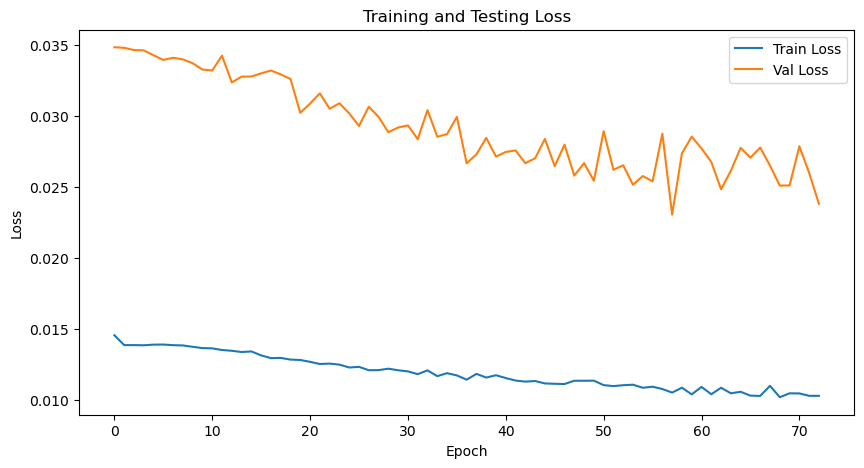

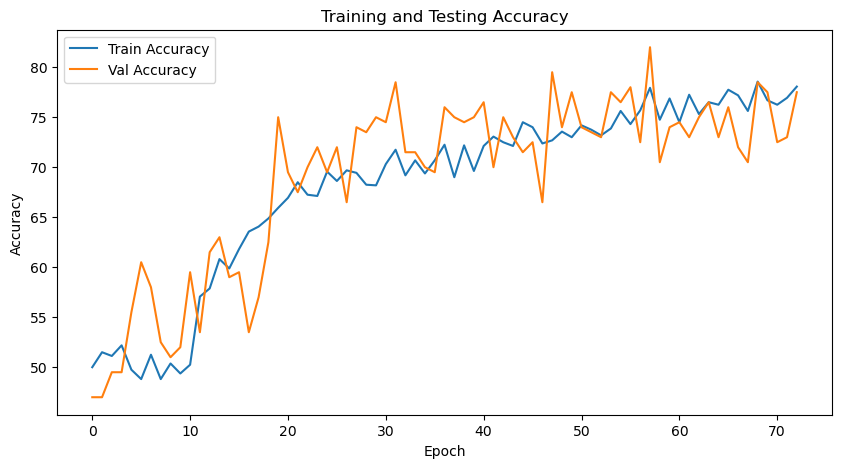

In [219]:
# Loss 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss_acc[0], label='Train Loss')
plt.plot(val_loss_acc[0], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# Accuracy 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss_acc[1], label='Train Accuracy')
plt.plot(val_loss_acc[1], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

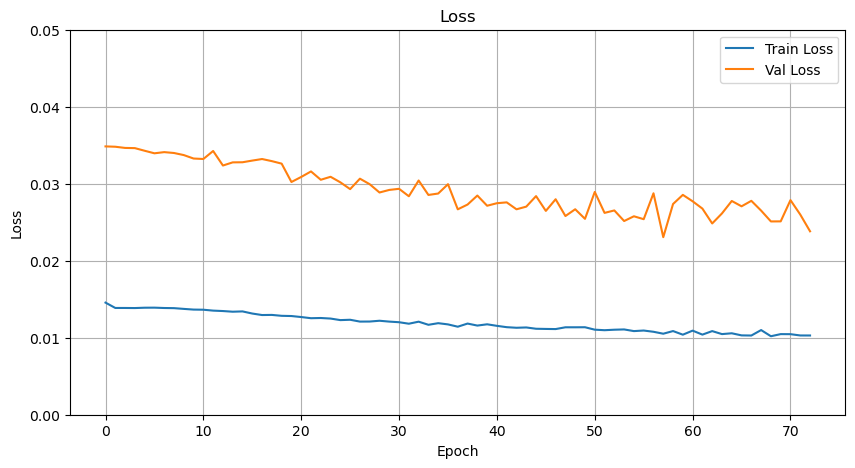

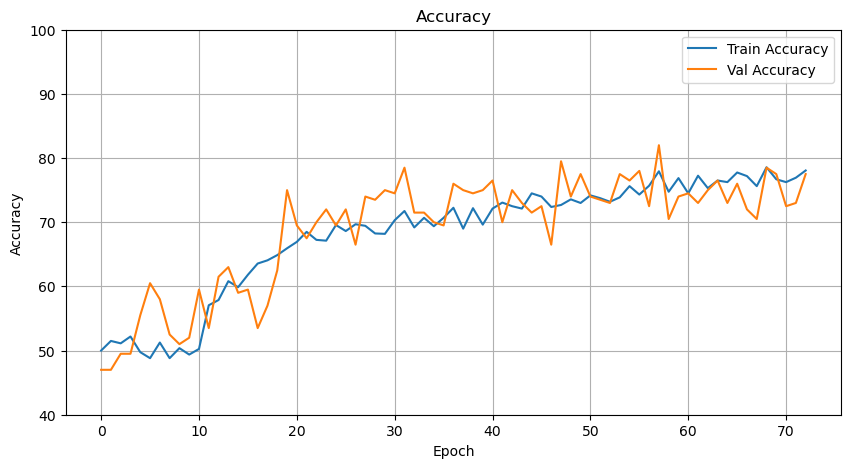

In [227]:
# Loss 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss_acc[0], label='Train Loss')
plt.plot(val_loss_acc[0], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.ylim(0, 0.05)
plt.grid()
plt.legend()
plt.show()

# Accuracy 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss_acc[1], label='Train Accuracy')
plt.plot(val_loss_acc[1], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.ylim(40, 100)
plt.show()

# test data predict

In [220]:
def predict(model, val_loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for image, label in val_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            label = label.float()
            output = model(image)
            # print(output.max(1, keepdim = True))
            prediction = output.round()  # 이진 분류에서는 반올림하여 0 또는 1로 변환
            
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_accuracy = 100. * correct / len(val_loader.dataset)
    return test_accuracy

predict(model, test_DL)

71.6867469879518

# 예측 진행 : 피자

In [221]:
# import cv2
# import matplotlib.pyplot as plt
# 
# 
# dongle = cv2.imread('../data/img/img3.png', cv2.IMREAD_GRAYSCALE)
# plt.imshow(dongle, cmap = 'gray')
# plt.axis("off")
# dongle = cv2.resize(dongle, (50, 50)) / 255
# 
# dongle = np.expand_dims(dongle, axis=0) # (50, 50) -> (1, 50, 50)
# 
# model(torch.FloatTensor(dongle)) # 아슬아슬하게 고양이가 된 동글이!! 이 정도면 제비뽑기를 하는 것이 나아보인다ㅠㅠ

In [222]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# # 모델 클래스를 초기화하고 모델 가중치를 로드합니다.
# model = MyModelClass(*args, **kwargs)
# model.load_state_dict(torch.load('model.pth'))
# model.eval()  # 모델을 추론 모드로 설정합니다.